In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings( 'ignore' )

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,7)

# File and Data Field Descriptions

**train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

**Destination** - The planet the passenger will be debarking to.

**Age** - The age of the passenger.

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

**Name** - The first and last names of the passenger.

**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [2]:
train = "/content/drive/MyDrive/Datasests/SPACE/train.csv"
test = "/content/drive/MyDrive/Datasests/SPACE/test.csv"
sub="/content/drive/MyDrive/Datasests/SPACE/sample_submission.csv"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv(train)
test = pd.read_csv(test)
sub = pd.read_csv(sub)

train['Transported'] = train['Transported'].astype(int)

In [5]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [6]:
train.shape, test.shape

((8693, 14), (4277, 13))

In [7]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

# Feature Engeeneing

In [8]:
TARGET = train[['Transported']]
train1 = train.copy()
test1 = test.copy()

In [9]:
def fill_cat(df: pd.DataFrame):
    col_feat = list(train1.select_dtypes(exclude=['int64', 'float64']).columns)
    col_feat.remove('PassengerId')
    for col in col_feat:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df
        
def fill_num(df: pd.DataFrame):
    col_feat = list(train1.select_dtypes(include=['int64', 'float64']).columns)
    col_feat.remove('Transported')
    for col in col_feat:
        df[col].fillna(df[col].median(), inplace=True)
    return df
        
def convert_bainary(df: pd.DataFrame):
    cols = ['VIP','CryoSleep']
    for col in cols:
        df[col] = df[col].astype(int)
    return df

#off
def log_transform(df: pd.DataFrame):
    col_feat = ['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' ]
    for col in col_feat:
        df[col] = np.log(df[col])
    return df

In [10]:
def create_columns(df: pd.DataFrame):
    df['deck'] = df['Cabin'].apply(lambda x: x.split('/')[0])
    df['num'] = df['Cabin'].apply(lambda x: x.split('/')[1])
    df['side'] = df['Cabin'].apply(lambda x: x.split('/')[2])
    df['LastName'] = df.Name.str.split(' ').str[1]
    
    df['group'] = df['PassengerId'].apply(lambda x: x[0:4])
    df['vr_spend']=df['RoomService']+df['FoodCourt']+df['ShoppingMall']+df['Spa']+df['VRDeck']
    df['no_spend'] = df['vr_spend'].apply(lambda row: 1 if row == 0 else 0)
    
    df['familyCounts'] = df.groupby(['LastName'])['LastName'].transform('count')
    # fill the values with name 'Disivering'
    df['familyCounts'] =  df['familyCounts'].apply(lambda x: 0 if x > 200 else x)
    
    df['isChild'] = df['Age'].apply(lambda x: 1 if x < 10 else 0)
    df['isOld'] = df['Age'].apply(lambda x: 1 if x > 60 else 0)
    #new columns form Age
    #df['0_18'] = df['Age'].apply(lambda x: 1 if x <= 18 else 0)
    #df['19_30'] = df['Age'].apply(lambda x: 1 if x > 18 and x <= 30  else 0)
    #df['more_30'] = df['Age'].apply(lambda x: 1 if x > 30 else 0)
    
    return df

def drop_cols(df: pd.DataFrame):
    df.drop('Name', axis=1, inplace=True)
    return df


def reduce_cardinality(df: pd.DataFrame ):
    col_ = ['Cabin', 'deck','num', 'side']
    for col in col_:
        #get a list of categories which contain one value
        tmp=list(df[col].value_counts()[df[col].value_counts()<2].index)
        #Replace with 'other'
        df[col]=df[col].apply(lambda x:'other' if x in tmp else x)
    return df

In [11]:
%%time
train1 = (train1.pipe(fill_cat).pipe(fill_num).pipe(convert_bainary))
test1 = (test1.pipe(fill_cat).pipe(fill_num).pipe(convert_bainary))

train1 = (train1.pipe(create_columns).pipe(drop_cols))
test1 = (test1.pipe(create_columns).pipe(drop_cols))

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 118 ms


In [12]:
train1.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,deck,num,side,LastName,group,vr_spend,no_spend,familyCounts,isChild,isOld
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,...,B,0,P,Ofracculy,0001,0.0,1,1,0,0
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,...,F,0,S,Vines,0002,736.0,0,4,0,0
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,...,A,0,S,Susent,0003,10383.0,0,6,0,0
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,...,A,0,S,Susent,0003,5176.0,0,6,0,0
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,...,F,1,S,Santantines,0004,1091.0,0,6,0,0


## EDA

In [13]:
cats = list(train1.select_dtypes(exclude=['int64', 'float64']).columns)
cats.remove('PassengerId')
for i in cats:
    print(i)
    le=LabelEncoder()
    arr=np.concatenate((train1[i], test1[i])).astype(str)
    le.fit(arr)
    train1[i]=le.transform(train1[i].astype(str))
    test1[i]=le.transform(test1[i].astype(str))

HomePlanet
Cabin
Destination
deck
num
side
LastName
group


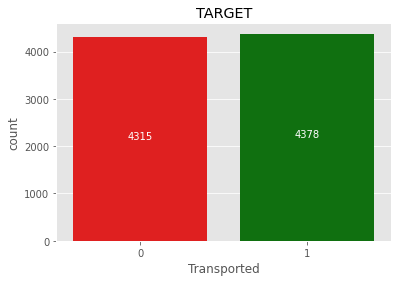

In [14]:
g = sns.countplot(x = 'Transported', data = train , palette=['g' if c == True else 'r' for c in train['Transported']]);
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{}'.format(round(height)),
            ha="center", color='white')
plt.title('TARGET');

**We have a balanced class**

## **Bivariate Analysis**

In [15]:
num_feat = train1.select_dtypes(exclude='object')
num_feat.drop('Transported', axis=1, inplace=True)

 ## **Numerical Variable**

In [16]:
num_feat.describe()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,deck,num,side,LastName,group,vr_spend,no_spend,familyCounts,isChild,isOld
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,...,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.649833,0.349362,4819.036466,1.494306,28.790291,0.022892,220.009318,448.434027,169.572300,304.588865,...,4.344185,1011.745197,0.516162,1194.661452,4632.389624,1440.866329,0.420223,5.297596,0.078109,0.025308
std,0.795183,0.476796,3032.501554,0.814966,14.341404,0.149568,660.519050,1595.790627,598.007164,1125.562559,...,1.775938,535.059773,0.499767,689.883384,2671.028856,2803.045694,0.493623,2.975454,0.268358,0.157067
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1968.000000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,531.000000,0.000000,626.000000,2318.000000,0.000000,0.000000,3.000000,0.000000,0.000000
50%,0.000000,0.000000,4815.000000,2.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1084.000000,1.000000,1194.000000,4629.000000,716.000000,0.000000,5.000000,0.000000,0.000000
75%,1.000000,1.000000,7563.000000,2.000000,37.000000,0.000000,41.000000,61.000000,22.000000,53.000000,...,6.000000,1438.000000,1.000000,1770.000000,6882.000000,1441.000000,1.000000,7.000000,0.000000,0.000000
max,2.000000,1.000000,9822.000000,2.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,...,7.000000,1893.000000,1.000000,2405.000000,9279.000000,35987.000000,1.000000,18.000000,1.000000,1.000000


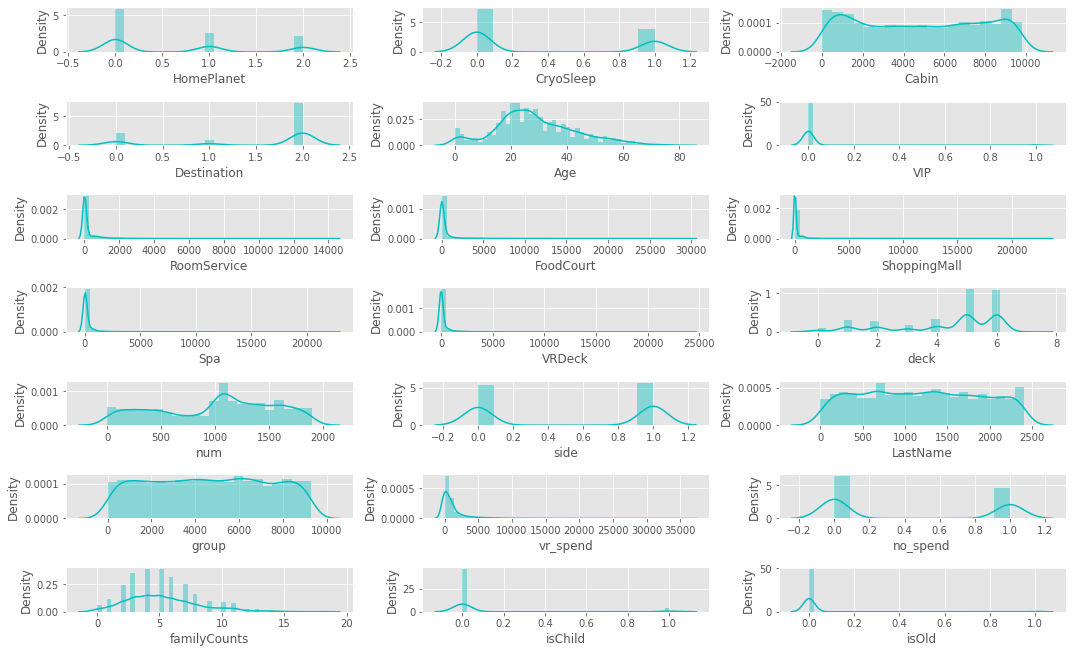

In [17]:
plt.figure(figsize=(15,10));
for i, feat in enumerate(num_feat):
    plt.subplot( 8, 3, i + 1 );
    sns.distplot(x=num_feat[feat], color = 'c')
    plt.xlabel(feat);
    plt.tight_layout();

**As we can see, some columns doesnt have a normal curve.**

# **MULTIVARIETED ANALYSI**S

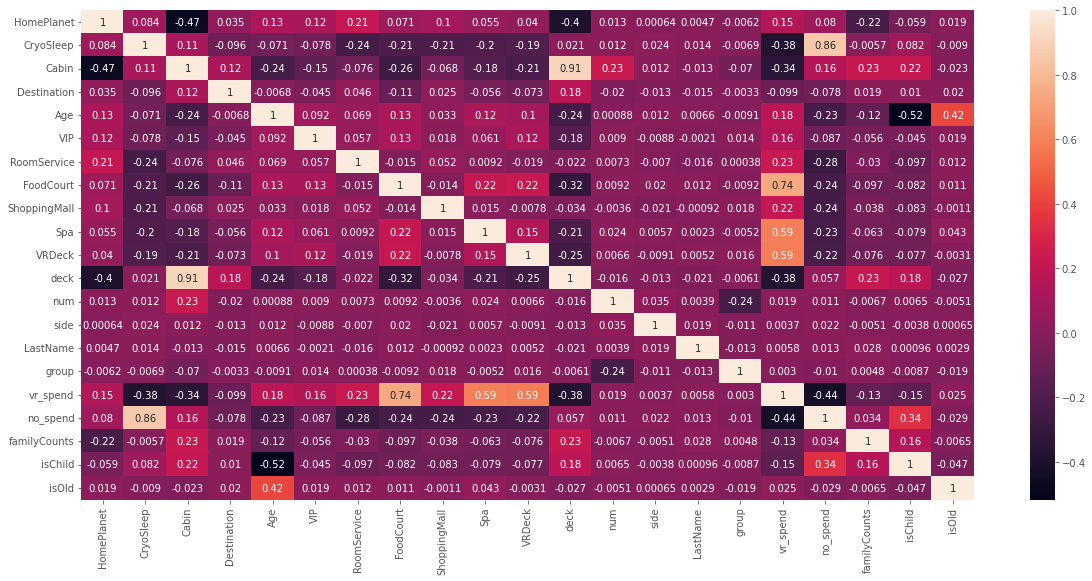

In [18]:
plt.figure(figsize=(20,9));
num_corr = num_feat.corr();
sns.heatmap(num_corr, annot=True);

# **CHECK OUTLIERS**

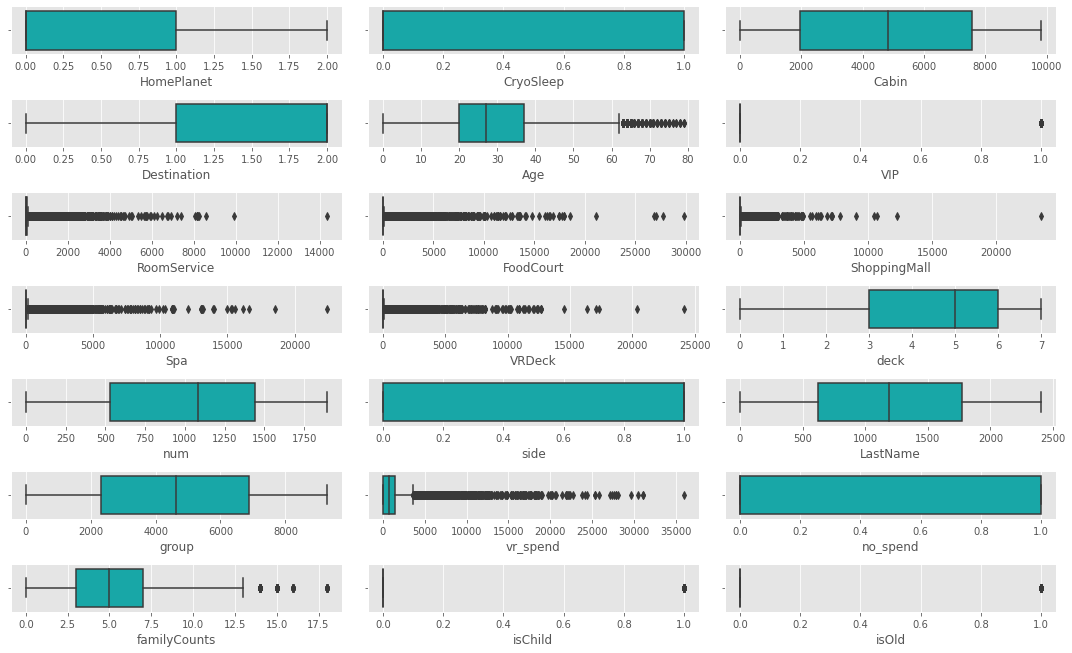

In [20]:
plt.figure(figsize=(15,10));
for i, feat_num in enumerate(num_feat):
    plt.subplot( 8, 3, i + 1 );
    sns.boxplot(x=num_feat[feat_num], color = 'c')
    plt.xlabel(feat_num);
    plt.tight_layout()

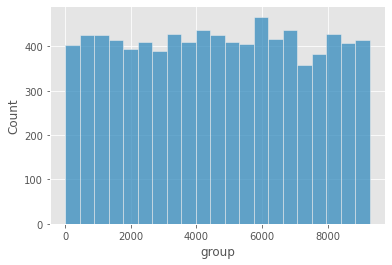

In [21]:
sns.histplot(x='group', data=train1)

**Okay Kaggle, I think you've overdone the outliers**

## **STANDARD SCALER**

In [22]:
X = train1.drop(['PassengerId'],axis=1)
X_test1 = test1.drop('PassengerId', axis=1)
y = TARGET

In [23]:
X.shape, X_test1.shape

((8693, 22), (4277, 21))

In [24]:
cols = list(X.columns)
cols.remove('Transported')

In [25]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X[cols] = sc.fit_transform(X[cols])
X_test1[cols] = sc.transform(X_test1[cols])

In [26]:
!pip install h2o

     |████████████████████████████████| 176.2 MB 1.9 kB/s 
  Created wheel for h2o: filename=h2o-3.36.0.4-py2.py3-none-any.whl size=176245474 sha256=53b722dff277e4a4f1fc165fa949aecba26b4e715edebdb5735a44ee63b39d29
  Stored in directory: /root/.cache/pip/wheels/66/7c/3b/6558f625a9415a96f7f650d33f1def07b6e30b0c871e8407a1
Successfully built h2o


In [27]:

import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

train_h2o = h2o.H2OFrame(X)
test_h2o = h2o.H2OFrame(X_test1)

# Identify predictors and response
x = train_h2o.columns
y = "Transported"
train_h2o[y] = train_h2o[y].asfactor()
x.remove(y)

# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=10, seed=24)
aml.train(x=x, y=y, training_frame=train_h2o)


ml_h2o = aml.predict(test_h2o)
preds_h2o = ml_h2o[0].as_data_frame().values.flatten()
preds_h2o

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14" 2022-01-18; OpenJDK Runtime Environment (build 11.0.14+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.14+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpd34rasp9
  JVM stdout: /tmp/tmpd34rasp9/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpd34rasp9/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.4
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_vzgmk8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


array([1, 0, 1, ..., 1, 1, 1])

## best result with 11 moldes

In [28]:
submission = pd.DataFrame({
        "PassengerId": sub["PassengerId"],
        "Transported":  preds_h2o})

submission['Transported'] = submission['Transported'].astype('bool')
submission.to_csv('pred_04.02_22:38.csv', index=False)
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True
